In [25]:
import pandas as pd
import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt


In [23]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
set_seed(42)

In [19]:
''' It returns:
Since the Folders with the images have the following structure:
- ROOT
-- Parasitized
-- Uninfected
I need to construct the corrisponding label
'''
images_dir_path = '../cell_images'  
images_dirs_paths = [name for name in os.listdir(images_dir_path) if name != '.DS_Store']
image_paths = []
image_classes = []
class_id = 0

def imglist(path_dir):    
    return [os.path.join(path_dir, image) for image in os.listdir(path_dir)]

''' It returns:
- image_paths: list of paths to all the images
- image_classes: list of labels
'''

for images_dir in images_dirs_paths:
    print(images_dir)
    if images_dir == "Parasitized":
        class_id = 1
    else:
        class_id = 0
    sub_dir = os.path.join(images_dir_path, images_dir)
    class_path = imglist(sub_dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)


Parasitized
Uninfected


In [20]:
# number of parasatized!
sum(np.array(image_classes) == 1)

13780

In [21]:
# number of uninfected!
sum(np.array(image_classes) == 0)

13780

In [64]:
SIZE = 92

In [65]:
image_data = []
labels = []

index = 0
for image_path in image_paths:
    if '.png' in image_path:
        image = cv2.imread(image_path)
        if image is not None:
            # Convert to RGB using PIL
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # Resize the image
            image = image.resize((SIZE, SIZE))
            image_data.append(np.array(image))
            labels.append(image_classes[index])  # Update this according to your label retrieval logic
        else:
            print(f"Image {image_path} could not be loaded")
    else:
        print(f"Image {image_path} is not a PNG file")
    index += 1

Image ../cell_images/Parasitized/Thumbs.db is not a PNG file
Image ../cell_images/Uninfected/Thumbs.db is not a PNG file


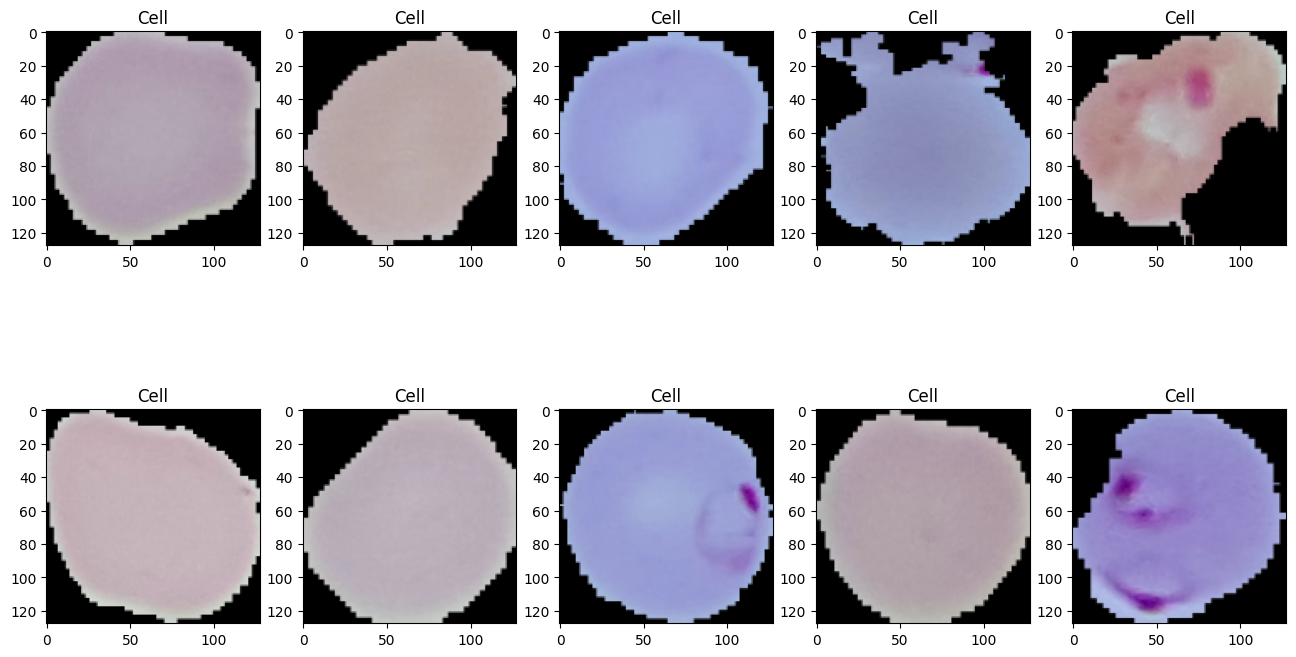

In [66]:
def  plot_random(path_images, num = 5):
    indices = np.random.choice(len(path_images),num*2,replace=False)

    plt.figure(figsize=(16,9))
    for i in range(num * 2): ## matplotlib starts from 1 differently from when using python
        plt.subplot(2,num, i+1) # 2 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("Cell")
        path_img = path_images[indices[i]]
        img = cv2.imread(path_img)  # Reads in BGR format (the output is in BRG) 
        im_resized = cv2.resize(img, (128, 128))
        plt.imshow(im_resized )
    
plot_random(image_paths, num = 5)

In [67]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(np.array(image_data), to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

In [68]:
## creating the validation set for choosing the best threshold!
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 0)

In [69]:
y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [70]:
good_mask = (y_train == [1,0])
good_mask = good_mask[:,0]
good_mask

array([False,  True, False, ...,  True, False, False])

## Let's remove the Parasitized instances!

In [61]:
X_train = X_train[good_mask]
y_train = y_train[good_mask]

In [119]:
from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
#32 is the number of filters!
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE , SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

model.add(MaxPooling2D((2, 2), padding='same'))
 
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

## The Loss is the Mean squared Error!
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

model.fit(X_train,X_train,verbose=1,epochs=100)

/Users/simoneboesso/Desktop/nuclei-segmentation/nuclei/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 92, 92, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 46, 46, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 23, 23, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 23, 23, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 24, 24, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 24, 24, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 46, 46, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 92, 92, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 32/621 ━━━━━━━━━━━━━━━━━━━━ 1:00 102ms/step - loss: 13881.2637

KeyboardInterrupt: 

In [113]:
import tensorflow as tf
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('Autoencoder_for_Denoising.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]

In [114]:
# The custom data generator used before did not shuffle the data! I had to change inside it!
batch_size = 128
history = model.fit(
    x=X_train, 
    y=X_train, 
    batch_size=batch_size, 
    epochs=100, 
    verbose=1, 
    validation_data=(X_val, X_val), 
    shuffle=True, 
    callbacks=callbacks
)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - loss: 5854.3701 - val_loss: 364.1344
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 395ms/step - loss: 302.1513 - val_loss: 222.5898
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 393ms/step - loss: 202.8195 - val_loss: 169.6700
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 393ms/step - loss: 161.2281 - val_loss: 150.5802
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 393ms/step - loss: 143.8087 - val_loss: 156.5240
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 394ms/step - loss: 138.3147 - val_loss: 129.6170
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 392ms/step - loss: 123.9367 - val_loss: 118.3952
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 394ms/step - loss: 118.2707 - val_loss: 112.1187
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 393ms/step - loss: 109.5085 - val_loss: 105.0514
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 394ms/step - loss: 102.6516 - val_loss: 107.9648
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 393ms/step -

KeyboardInterrupt: 

In [115]:
import numpy as np
from sklearn.metrics import f1_score, mean_squared_error


# This assumes class 1 is the "anomalous" class and the rest are "normal"
binary_y_test = np.argmax(y_test, axis=1) == 1  # This will be True for anomalies, False for normal

binary_y_test = binary_y_test.astype(int)


# Get the model's predictions for X_test
preds = model.predict(X_test)
print(preds.shape)


best_f1_score = 0
best_threshold = 0

# Calculate MSE for each image
mse_per_image = np.mean(np.square(preds - X_test), axis=(1, 2, 3))  # Averaging over all dimensions except the batch
print(mse_per_image)
# Iterate over a range of threshold values to determine the best one
for th in np.linspace(0, np.max(mse_per_image), 100):
    # Classify each image as 1 (anomaly) or 0 (normal) based on the MSE threshold
    image_classifications = (mse_per_image > th).astype(int)

    # Compute the F1 score for this threshold
    current_f1_score = f1_score(binary_y_test, image_classifications, average='binary')

    # Update the best F1 score and corresponding threshold
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = th

print(f"Best F1 Score: {best_f1_score} at Threshold: {best_threshold}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
(5512, 92, 92, 3)
[53.220356 56.57628  40.13873  ... 83.44953  71.14187  61.785458]
Best F1 Score: 0.6861334071408801 at Threshold: 51.48350108753551
